In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.preprocessing import binarize
from sklearn.model_selection import train_test_split

In [ ]:
df = pd.read_csv('/content/labeled_twitter_depressive_full_clean_km2.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123984 entries, 0 to 123983
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   text            123984 non-null  object 
 1   depression      123984 non-null  float64
 2   not_depression  123984 non-null  float64
 3   cluster         123984 non-null  int64  
dtypes: float64(2), int64(1), object(1)
memory usage: 3.8+ MB


In [ ]:
df = df.drop(['depression', 'not_depression'], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123984 entries, 0 to 123983
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   text     123984 non-null  object
 1   cluster  123984 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.9+ MB


In [ ]:
df.shape

(123984, 2)

In [ ]:
df.groupby('cluster').count()

,text
cluster,
0,70509
1,53475


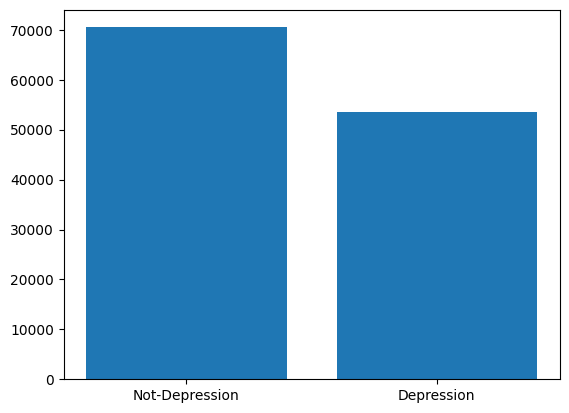

In [ ]:
classes = df.cluster.unique()
counts = []

for i in classes:
  count = len(df[df.cluster==i])
  counts.append(count)

plt.bar(['Not-Depression', 'Depression'], counts)
plt.show()

In [ ]:
from sklearn.preprocessing import LabelEncoder

X = df['text']
encoder = LabelEncoder()
y = encoder.fit_transform(df['cluster'])
print("shape of input data: ", X.shape)
print("shape of target variable: ", y.shape)

shape of input data:  (123984,)
shape of target variable:  (123984,)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import regularizers

max_words = 5000
max_len = 200
embedding_dim = 128

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)

X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

word_index = tokenizer.word_index
print(f'Found {len(word_index)} unique tokens.')
vocab_size = len(word_index) + 1

X_train_tweets = pad_sequences(X_train_sequences, maxlen=max_len)
X_test_tweets = pad_sequences(X_test_sequences, maxlen=max_len)

Found 77237 unique tokens.


In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

oversample = SMOTE(sampling_strategy=1, random_state=42)
over_X_train, over_y_train = oversample.fit_resample(X_train_tweets, y_train)

In [ ]:
from collections import Counter

print('Original dataset shape {}'.format(Counter(y_train)))
print('Resampled dataset shape {}'.format(Counter(over_y_train)))

Original dataset shape Counter({0: 56407, 1: 42780})
Resampled dataset shape Counter({0: 56407, 1: 56407})


In [ ]:
print(np.count_nonzero(over_y_train == 0))
print(np.count_nonzero(over_y_train == 1))

print(np.count_nonzero(y_test == 0))
print(np.count_nonzero(y_test == 1))

56407
56407
14102
10695


In [ ]:
import keras
keras.__version__

'2.15.0'

In [ ]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# matthews_correlation_coefficient
def mcc_m(y_true, y_pred):
    tp = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    tn = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    fp = K.sum(K.round(K.clip((1 - y_true) * y_pred, 0, 1)))
    fn = K.sum(K.round(K.clip(y_true * (1 - y_pred), 0, 1)))

    num = tp * tn - fp * fn
    den = (tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)
    return num / K.sqrt(den + K.epsilon())

def balanced_acc_m(y_true, y_pred):
    tp = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    tn = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    fp = K.sum(K.round(K.clip((1 - y_true) * y_pred, 0, 1)))
    fn = K.sum(K.round(K.clip(y_true * (1 - y_pred), 0, 1)))

    sensitivity = tp / (tp + fn)
    specifity = tn / (fp + tn)

    return (sensitivity + specifity) / (2 + K.epsilon())

In [ ]:
from keras.models import Sequential
from keras import layers
from keras import regularizers
from keras import backend as K
from keras.callbacks import ModelCheckpoint

from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Dropout

In [ ]:
model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, input_length=max_len))
model.add(layers.LSTM(64, dropout=0.5, activation='tanh'))
model.add(layers.Dense(32, activation='tanh'))
model.add(layers.Dense(8, activation='tanh'))
model.add(layers.Dense(2, activation='tanh'))
model.add(layers.Dense(1,activation='sigmoid', kernel_regularizer=regularizers.l2(0.1)))

#model.summary()

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy', metrics=['accuracy', balanced_acc_m, precision_m, recall_m, f1_m, mcc_m, keras.metrics.AUC()])
checkpoint = ModelCheckpoint("best_epoch_rnn_model.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='auto', period=1, save_weights_only=False)
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10)
history = model.fit(over_X_train, over_y_train, batch_size=64, epochs=50, validation_data=(X_test_tweets, y_test), callbacks=[checkpoint, stop_early])

Epoch 1/50
1763/1763 [==============================] - ETA: 0s - loss: 0.6163 - accuracy: 0.7708 - balanced_acc_m: 0.7712 - precision_m: 0.7874 - recall_m: 0.7479 - f1_m: 0.7628 - mcc_m: 0.5442 - auc: 0.8310
Epoch 1: val_accuracy improved from -inf to 0.80473, saving model to best_epoch_rnn_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1763/1763 [==============================] - 59s 29ms/step - loss: 0.6163 - accuracy: 0.7708 - balanced_acc_m: 0.7712 - precision_m: 0.7874 - recall_m: 0.7479 - f1_m: 0.7628 - mcc_m: 0.5442 - auc: 0.8310 - val_loss: 0.5469 - val_accuracy: 0.8047 - val_balanced_acc_m: 0.8071 - val_precision_m: 0.7494 - val_recall_m: 0.8235 - val_f1_m: 0.7815 - val_mcc_m: 0.6089 - val_auc: 0.8825
Epoch 2/50
1763/1763 [==============================] - ETA: 0s - loss: 0.5495 - accuracy: 0.8038 - balanced_acc_m: 0.8038 - precision_m: 0.8122 - recall_m: 0.7911 - f1_m: 0.7985 - mcc_m: 0.6082 - auc: 0.8648
Epoch 2: val_accuracy did not improve from 0.80473
1763/1763 [==============================] - 33s 19ms/step - loss: 0.5495 - accuracy: 0.8038 - balanced_acc_m: 0.8038 - precision_m: 0.8122 - recall_m: 0.7911 - f1_m: 0.7985 - mcc_m: 0.6082 - auc: 0.8648 - val_loss: 0.5496 - val_accuracy: 0.8035 - val_balanced_acc_m: 0.8074 - val_precision_m: 0.7434 - val_recall_m: 0.8325 - val_f1_m: 0.7822 - val_mcc_m: 0.6

In [ ]:
# evaluate the model
y_predict_rnn = model.evaluate(X_test_tweets, y_test, verbose=0)
y_predict_rnn

[0.571509838104248,
 0.7966286540031433,
 0.798700749874115,
 0.7420174479484558,
 0.8126487135887146,
 0.7692878842353821,
 0.5922278761863708,
 0.8321689367294312]

(0.0, 0.6234315827488899)

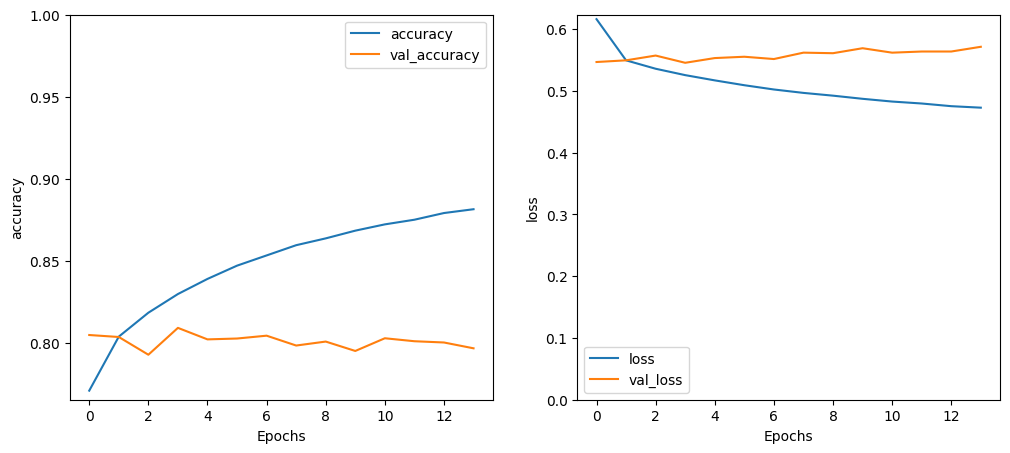

In [ ]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [ ]:
history.history

{'loss': [0.6162642240524292,
  0.5495322346687317,
  0.5359582901000977,
  0.5256147980690002,
  0.5171167254447937,
  0.5092757344245911,
  0.5023670196533203,
  0.4968394935131073,
  0.49236658215522766,
  0.4872695803642273,
  0.48282772302627563,
  0.47967031598091125,
  0.47533273696899414,
  0.4729170501232147],
 'accuracy': [0.7708174586296082,
  0.8037566542625427,
  0.8183292746543884,
  0.8297197222709656,
  0.8389384150505066,
  0.847022533416748,
  0.8532540202140808,
  0.8594943881034851,
  0.863651692867279,
  0.8683585524559021,
  0.8721878528594971,
  0.8750243782997131,
  0.8791018724441528,
  0.8814243078231812],
 'balanced_acc_m': [0.7711843848228455,
  0.803800106048584,
  0.8181663155555725,
  0.829467236995697,
  0.8390733003616333,
  0.8469753861427307,
  0.8531292080879211,
  0.8592513799667358,
  0.8636497855186462,
  0.8685997128486633,
  0.8720947504043579,
  0.8750783801078796,
  0.8789111375808716,
  0.8814060688018799],
 'precision_m': [0.7873529195785522

In [ ]:
import json

results_rnn = json.dumps(history.history)

with open('results_rnn_full_clean_smote-train_bs-64_depressive.json', 'w') as archivo:
    archivo.write(results_rnn)

# Load the RNN model

In [ ]:
metric_list = {"recall_m": recall_m, "precision_m": precision_m, "f1_m": f1_m,
               "mcc_m": mcc_m, "balanced_acc_m": balanced_acc_m}

load_rnn_model = tf.keras.models.load_model('/content/best_epoch_rnn_model.h5', custom_objects=metric_list)

In [ ]:
y_predict_rnn_load = load_rnn_model.evaluate(X_test_tweets, y_test, verbose=0)
y_predict_rnn_load

[0.5455920696258545,
 0.8090897798538208,
 0.8091035485267639,
 0.7668748497962952,
 0.8041090965270996,
 0.7784021496772766,
 0.6143144965171814,
 0.857459306716919]